# TEMPORAL SET PREDICTION USING GRAPH BASED APPROACHES.
This is the accompanying notebook to the Medium Blog entitled ["'Don't forget the milk again!': Predicting temporal shopping sets using Graph Neural Networks"](https://medium.com/@wwwidonja/dont-forget-the-milk-again-adc8924fdbe1). It was prepared as part of the Stanford CS224W course project @UL FRI; 2021/22 by Sara Bizjak, Maruša Oražem and Vid Stropnik. While this notebook is meant to be self-sufficient, it will be best experienced by concurrently reading the accompanying blog, linked above. Here, a more robust and theorethical overview of the model and problem at hand will be given, while the blog contextualizes the intent of the model more thoroughly and also gives a good introduction into the theory used here.

### Introduction
In this notebook, we'll be implementing a model for temporal set prediction. Namely, we'll be working on the example of predicting future shopping carts by observing the purchasing habit of a given household in the past.

We'll be using a model proposed by [Yu et. al. in their 2020 paper entitled "Predicting Temporal Sets with Deep Neural Networks"](https://dl.acm.org/doi/10.1145/3394486.3403152).

As for the data, we will be using the first couple of months from the [Dunhumby's "The Complete Journey" dataset](https://medium.com/r?url=https%3A%2F%2Fwww.dunnhumby.com%2Fsource-files%2F). It contains transaction level data for over 2500 households in a general goods store.

### Problem formalization
We are given a sequence of sets *{$s^{1}_{i}$, $s^{2}_{i}$, ... $s^{T_{max}}_{i}$}.* Each set in this sequence describes the items that were purchased by household *i* on their *t-th* visit to the general goods store, where $t \in \{ 1 \dots T_{max} \}$-th . For example, if $s^{1}_{42} = \{\text{item}_{26}, \text{item}_{07}, \text{item}_{33}\},$ this means that the household with the identifier *42* bought three items on their first visit to this supermarket. Namely, they bought the items with identifiers 26, 07 and 33.

We want to train a deep neural network that will be able to take into account both the similarities between individual items, as well as the temporal purchasing habits of individual households. With such a model, we want to predict the probable contents of a subsequent shopping basket by household *i*. More formally, we want to train the function *f* in:
$$ s^{T_{max}+1} = f\big{(} s^{1}_{i}, s^{2}_{i}, \dots s^{T_{max}}_{i} | \Theta_{f}  \big{)}, $$ where $\Theta_{f}$ is the set of all trainable parameters of our model.

## Preparation & packages
First, we'll import some packages that will help us get the job done.
The main bulk of our code will be written in Pytorch (torch) and Pytorch Geometric (torch_geometric). As we'll soon see, we'll construct the representations of our sets using networks: a data structure composed of vertices and edges. To parse them efficiently, we will use the well established network library, [networkx](https://networkx.org/). We'll also extract some data from the [originalsource transaction csv file]() <font color="red"> <---link needed here </font>. We'll use [pandas](https://pandas.pydata.org/) only to process that.

Finally, we use some standard or utility libraries like [os](https://docs.python.org/3/library/os.html), [pickle](https://wiki.python.org/moin/UsingPickle) and [tqdm](https://github.com/tqdm/tqdm) for more efficient printouts, temporary file processing and system querying. These won't be crucial for the understanding of the text below.

In [2]:
import torch
import torch.nn as nn
import torch_geometric.nn
from torch_geometric.nn import GCNConv
import pandas as pd
import os
from os import path
import networkx as nx
from torch_geometric.utils import from_networkx
from tqdm import tqdm
import pickle

Here, we prepare some static variables that we're going to neeed later. From the source dataset, we get a list of all unique items codes. We will also save their total number under `num_all_unique_items`.import torch

In [23]:
original_csv = pd.read_csv(os.path.join('..\\data\\', 'transaction_data_smaller.csv'))
all_unique_items = [i for i in list(original_csv.PRODUCT_ID.unique())]
num_all_unique_items = len(all_unique_items)
reverse_uid = {str(item_code) : idx for idx, item_code in enumerate(all_unique_items)}
print(f'There are a total of {num_all_unique_items} unique items in our dataset')


## we initialize these dimensions which will be explained later here, just so we can efficiently pickle our temporary files. These will be explained later.
f0 = f1 = f2 = 32
hidden_dims = [32, 32]

There are a total of 24375 unique items in our dataset


# Part 1: Constructing weighted graphs.
As seen in the accompanying blog post, our method proposes a weighted graph convolutional network on dynamic graphs, which represent individual shopping carts. Very briefly, we need to first construct the sets from the transaction level source `.csv` file. Then, we extract the (normalized) frequency of co-occuring item pairs. Finally, we transform each shopping set to a weighted graph, where items that co-occur in it are connected with edges, weighted by the mentioned co-occurrence frequency. To each such graph, we also add self-loops of singletons that don't appear in this particular shopping cart, but are purchased by the household in some other shopping cart $s_{i}^{t}$.

The first step of our approach is thus to construct these graphs. As this is quite computationally expensive, we offload the creation of these graphs into a different colab, which [you can access by clicking here](https://colab.research.google.com/drive/1vyahNq6Jo60Bg4tcMv0mfqs9Lwz5uXpC?usp=sharing).
**In this colab, we'll work with the outputs from that colab. You can access our outputs [here]() <font color="red"><--- Link needed here. </font>. Just put unzip them and put them in the root directory folder 'Graphs' to continue working.**

In the following cell, we construct the dictionary `shopping_per_hh`. It's keys denote the codes of all housholds in the `Graphs` folder, while it's values will be lists of `torch.data.Data` objects, representing shopping baskets from the household's discrete trips to the general goods store. Hence, at `shopping_per_hh["1000"][4]`, we will find the `torch.data.Data` graph, describing household's `hid="1000"` fourth tip to the store and the items they purchased.

Into each `torch.data.Data` object, we will read the weighted graphs, constructed by our external colab and convert them to pytorch's way of distinguishing representing data. We'll add some aditional info to each graph - these will come handy later:
* into `data.x`, we will save a tensor of size $(N, 1)$, where *N* is the number of nodes appearing in this graph. This tensor will denote node features, needed for our eventual GCN model to run. Because we want to treat all nodes equally, we give them equivalent features (ones).
* into `data.id`, we will save a 'translator', which maps from the node's identifier in the graph ($i \in [0, N-1]$) to the the identifier of the item it represents in Dunhumby's original dataset.
* into `data.y`, we will save a sparse tensor of size $(\hat{N}, 1)$, where $\hat{N}$ is the number of all items, appearing across all households in the dataset. The tensor will be a multi-hot encoding and will hold ones in the indices, corresponding to the indices of the items contained in this graph's shopping basket in our static matrix representations of all items $E$. (to learn more about this, reference the Medium blog). We construct these tensors using the `reverse_uid` dictionary, that we initialized before. This dictionary will ( upon the initialization of `E` later ) serve as a reference map between the row indices of $E$ and the dataset item codes.

In [4]:
shopping_per_hh = {}

#This is just a test -- we're only constructing the graphs for houshold id 22 as a proof of concept!
print('Creating graphs from files')
if not path.exists(path.join("..\\data\\pickles", f"shopping_per_hh_F1_{f1}_hid_{hidden_dims}.pkl.gz")):
    for filename in tqdm(os.listdir("../data/Test-Graphs/content/Graphs/")):
        splits = filename.split('_')
        hh_id = splits[0]
        if hh_id not in shopping_per_hh: shopping_per_hh[hh_id] = []


        ## we construct a NX graph and cast it to pytorch.data.Data
        G = nx.Graph(nx.read_pajek(os.path.join("../data/Test-Graphs/content/Graphs/",filename)))
        data = from_networkx(G)
        
        # We get a list of all items actually contained in the basket. These are items that are isolates in the NetworkX graph.        
        articles_in_basket = [i for i in list(G.nodes()) if i not in list(nx.isolates(G))]
        
        
        #we construct the custom data features we discussed above...
        gt = torch.zeros(num_all_unique_items)
        indices_in_E = [reverse_uid[i] for i in articles_in_basket]
        gt[indices_in_E] = 1
        gt = gt.to_sparse()
        x = torch.ones(G.number_of_nodes(), 1)
        
        #..., add them to the graph representation and save the graph in the dictionary.
        data.x = x
        data.id = {i:code for (i, code) in zip ([i for i in range(G.number_of_nodes())], list(G.nodes()))}
        data.y = gt
        shopping_per_hh[hh_id].append(data)
    
    with open(path.join("..\\data\\pickles", f"shopping_per_hh_F1_{f1}_hid_{hidden_dims}.pkl.gz"), "wb") as f:
        pickle.dump(shopping_per_hh, f)

else:
    with open(path.join("..\\data\\pickles", f"shopping_per_hh_F1_{f1}_hid_{hidden_dims}.pkl.gz"), "rb") as f:
        shopping_per_hh = pickle.load(f)
        
print(f'torch.data.Data lists have been created for {len(list(shopping_per_hh.keys()))} households')

Creating graphs from files
torch.data.Data lists have been created for 1626 households


# Part 2: Convolutions on weighted graphs
Now that we have our weighted graphs, it's time to create the first module of our temporal set prediction model - a stack of convolutional layers.

To quickly recap and slightly formalize what we've done so far: The input for this module is a sequence of dynamic graphs $\mathbb{G}_i = \{\mathcal{G}_i^1,...\mathcal{G}_i^T\}$, where graph $\mathcal{G}_i^t \in \mathbb{G}_i$ contains all nodes ever purchased by this household. These are represented as $\{e_{i,j}^t \in \mathbb{R}^{N \times 1}, \forall v_{i,j} \in \mathcal{V}_i\}$. ($N \times 1$ is the dimension of node features ( equal to `in_features` and *i* is the considered household).

For each graph $\mathcal{G}_i$, the output of this convolutional module is a new sequence representation, which we will denote as  $\{c_{i,j}^t \in \mathbb{R}^{F_{1}}, \forall v_{i,j} \in \mathcal{V}_i\}$. ($F_{1}$ is the new dimension equal to `out_features`). We've set the value of item embeddings already (for naming the stored files so we don't override something), so we can print it out! We'll do the same for the dimensionality of our the hidden layers GCN layers, which we'll look at next.

In [5]:
print(f'Our convolutional module will output {f1}-dimensional embeddings')
print(f'Our convolutional module will have {len(hidden_dims)} hidden layers. The dimensionalities are : {hidden_dims}')

Our convolutional module will output 32-dimensional embeddings
Our convolutional module will have 2 hidden layers. The dimensionalities are : [32, 32]


To reduce the parameter scale and also make our method flexible to deal with sequences with variable lengths, a parameter sharing strategy is adopted. The weighted convolutions are implemented by propagating information of elements in each dynamic graphs as follows. For graph $\mathcal{G}_i$
$$c_{i,j}^{t,l+1} = \sigma\left( b^l + \sum_{k \in N_{i,j}^t \cup \{j\}}   A_i^t[j,k] \cdot \left( W^t c_{i,k}^{t,l} \right) \right),$$ where $A_i^t[j,k]$ represents the item in j-th row and k-th column of matrix $A_i^t$, which is the edge weight of $v_{i,j}$ and $v_{i,k}$ in graph $\mathcal{G}_i^t$. The superscript index *l* here denotes the convolutional layer in which the representation is located, and $\sigma$ denotes the chosen non-linearity for our conovlutional layer. In our case, this will be ReLU. <font color="red"> Are we actually doing parameter sharing at the moment? </font>

**Convolutional layer**

We are going to override the `nn.Module` to construct our convolutional layer.
For the convolutions, we're going to use the `GCNConv` layer from the PyG library. The convolutions are realized as follows:

$$\mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
\mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},$$

where $\mathbf{\hat{A}} = \mathbf{A + I}$ is the adjacency matrix of a graph with inserted self-loops, and $\mathbf{\hat{D}}$ is its diagonal degree matrix.
PyG makes the use of convolutions simple by simpy asking us to input the node feature tensor (data.x) of shape `[num_of_nodes, num_of_features]` and the `torch.data.Data` object's `edge_index`, a graph connectivity tensor in `COO` format with shape `[2, num_of_edges]`

Here are some other terms needed to understand the following code, where we construct our convolutional module:

`nn.ModuleList()` - Holds submodules in a list. <br>
`nn.ReLU()` - Applies the rectified linear unit function element-wise: ReLU(x) = max(0,x) <br>
`nn.BatchNorm1d` - Applies Batch Normalization over a 2D or 3D input. $y=\frac{x-E[x]}{\sqrt{var[x]+\epsilon}} \cdot \gamma + \beta$, The mean and standard-deviation are calculated per-dimension over the mini-batches and \gammaγ and \betaβ are learnable parameter vectors of size C (where C is the input size).

In [6]:
class weighted_GCN(nn.Module):
    def __init__(self, in_features, hidden_sizes, out_features):
        '''
        :param in_features: int, number of input features
        :param hidden_sizes: List[int], list of integers of hidden sizes
        :param out_features: int, number of output features
        '''
        super(weighted_GCN, self).__init__()
        # we are going to use 3 layers, first graph conv we wrote before, ReLu function and normalization
        gcns, relus, bns = nn.ModuleList(), nn.ModuleList(), nn.ModuleList()
        
        # layers for hidden_size
        input_size = in_features
        for hidden_size in hidden_sizes:
            
            # go through all the hidden layers and call all three functions (modules)
            gcns.append(GCNConv(in_channels=input_size, 
                            out_channels=hidden_size,
                            improved=False,
                            cached=False,
                            add_self_loops=False,
                            normalize=False,
                            bias=False)) 
            
            relus.append(nn.ReLU())
            bns.append(nn.BatchNorm1d(hidden_size))
            
            input_size = hidden_size # next layer start size will be output from one layer before
        
        # output layer
        gcns.append(GCNConv(in_channels=hidden_sizes[-1], 
                            out_channels=out_features,
                            improved=False,
                            cached=False,
                            add_self_loops=False,
                            normalize=False,
                            bias=False
                            )
                   )
        relus.append(nn.ReLU())
        bns.append(nn.BatchNorm1d(out_features))
        self.gcns, self.relus, self.bns = gcns, relus, bns

    def forward(self, x, adj_t):
        h = x
        for gcn, relu, bn in zip(self.gcns, self.relus, self.bns):
            
            h = gcn(h, adj_t)
            h = bn(h.transpose(1, -1)).transpose(1, -1)
            h = relu(h)
        return h

For easier understanding of the the process, we will follow the transformation that one input makes throughout it's journey through our model. Let this be the purchasing habits of household `"1000"`. Feel free to toy around and change the index of the chosen household in the following cell, if you want to follow a different household (eg. try "1001" or "1002")!

In [7]:
CHOSEN_HH = "1000"

Run the following cell to learn more about the houshold we'll be looking at.

In [8]:
baskets = shopping_per_hh[CHOSEN_HH]

print(f'The chosen household ({CHOSEN_HH}) made {len(baskets)} trips to the store in the dataset.\n'
      f'We\'ll be predicting the contents of their {len(baskets)}th basked based on what '
      f'they bought in the preceding {len(baskets)-1}.\n'
      f'This houshold purchased {len(list(baskets[0].id.keys()))} items in all of its {11} visits to the store.\n'
      f'Their final basket contains {len(list(baskets[-1].y.to_dense().nonzero()))} items.' )

Xbaskets = baskets[:-1]
Ybaskets = baskets[-1]

The chosen household (1000) made 11 trips to the store in the dataset.
We'll be predicting the contents of their 11th basked based on what they bought in the preceding 10.
This houshold purchased 88 items in all of its 11 visits to the store.
Their final basket contains 25 items.


In the following cell, we initialize the convolutional module and send the `CHOSEN_HH`'s $T_{max}-1$ baskets through.

In [9]:
in_dims = baskets[0].num_features
convolutional_model = weighted_GCN(in_dims,
                                   hidden_dims,
                                   f1)
convoluted_Xbaskets = []
for basket_graph_at_t in Xbaskets:
    with torch.no_grad():
        o = convolutional_model(basket_graph_at_t.x, basket_graph_at_t.edge_index)
        convoluted_Xbaskets.append(o)

print(f'The newly created list \'convoluted_Xbaskets\' is now a {type(convoluted_Xbaskets)} of length {len(convoluted_Xbaskets)},'
      f'where each entry is of size {convoluted_Xbaskets[0].size()}')

The newly created list 'convoluted_Xbaskets' is now a <class 'list'> of length 10,where each entry is of size torch.Size([88, 32])


## Part 3: Attention-based Temporal Dependency Learning
Now, we will try to learn temporal dependency among products. As we know from everyday life, some elements (products) will appear in our basket quite frequently and regularly, while others will appear irregularly and occasionally. This makes the temporal dependency learning really hard!

Previous models, such as RNNs, fail to model this kind of data, because they do not take into account the temporal dependency learning. We are going to construct our model, using self attention, so that we will not loose this information, we are going to construct a temporal dependeny learning component.

To make a proper input to this component, we will slightly reshape the sequences we have constructed in the previous step. We will do this to make this masked self-attention module more general. The input sequence will be a 3D tensor of shape `(nodes_num, T_max, features_num)`. Let us first reshape the working example and continue from there.

In [10]:
item_embeddings = {j : [] for j in range(len(convoluted_Xbaskets[0]))}
for basket in range(len(convoluted_Xbaskets)):
    for item in range(len(convoluted_Xbaskets[basket])):
        ## add the embeddings for each item to its corresponding temporal index t in the newly created list
        item_embeddings[item].append(convoluted_Xbaskets[basket][item].tolist())

convoluted_Xbaskets = torch.tensor(list(item_embeddings.values()))
print(f'The reshaped \'convoluted_Xbaskets\' is now a {type(convoluted_Xbaskets)} of shape {convoluted_Xbaskets.size()}')

The reshaped 'convoluted_Xbaskets' is now a <class 'torch.Tensor'> of shape torch.Size([88, 10, 32])


The inputs to this component are the sequences of embeddings standing for the chosen household $i$, denoted as $\mathbb{C}_i = \{C_{i,1},...,C_{i,|\mathcal{V}_i|}\} $ where $C_{i,j}=\{c_{i,j}^1,...,c_{i,j}^T\}$ are the representations of $v_{i,j}$ over time.
With bolded symbol $\boldsymbol{C}_{i,j} \in \mathbb{R}^{t \times F_1}$ we denote the stacked matrix representation of $C_{i,j}$, where the $t$-th row respresents $c_{i,j}^t$.

The output is the temporal information laden shared representation $\mathbb{Z}_i = \{z_{i,1},...,z_{i,|\mathcal{V}_i|}\}$, where $z_{i,j} \in \mathbb{R}^{F_2}$
indicates the representation of element $v_{i,j} \in \mathcal{V}_i$.

**Masked self-attention**

First part of this component deals with aggregating the stacked representations $\boldsymbol{C}_{i,j}$ into new representations $Z_{i, j}$ considering temporal dependency for each element. Thus, the new representations are computed as follows

$$Z_{i,j} = softmax\left( \frac{(C_{i,j}W_q) \cdot (C_{i,j}W_k)^T}{\sqrt{F''}} + M_i \right) \cdot (C_{i,j}W_v),$$

where $W_q \in \mathbb{R}^{F_1 \times F_2}$, $W_k \in \mathbb{R}^{F_1 \times F_2} $, $W_v \in \mathbb{R}^{F_1 \times F_2}$ are trainable parameters and $Z_{i,j} \in \mathbb{R}^{T \times F_2}$ is the stacked representation of $v_{i,j}$'s sequence.
With $M_i$ we denote the mask matrix, which is used to avoid the future information leakage and to ensure that only knowledge from previous state is considered. The mask matrix is defined as 
$$\begin{equation}
  M_i^{t,t'}=\begin{cases}
    0, & \text{if $t<t'$},\\
    -\infty, & \text{otherwise}.
  \end{cases}
\end{equation}$$

**Aggregation** 

Second part of this component compress the new representations $Z_{i, j}$ into more compact representation of $v_{i, j}$, denoted as $z_{i, j} \in \mathbb{R}^{F_2}$.
More formally, we aggregate the sequential information into a vectorized representation by the weighted aggregation equation, defined as
$$ z_{i, j} = \left( (Z_{i, j} \cdot w_{agg} )^T \cdot Z_{i, j} \right) ^T,$$
where $ w_{agg} \in \mathbb{R}^{F_2}$ is a trainable parameter used for learning the importance of different time states.


We define the self-attention module and its aggregation module in the following cells:

In [11]:
import numpy as np
class masked_self_attention(nn.Module):

    def __init__(self, input_dim, output_dim, n_heads=4):
        super(masked_self_attention, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        self.n_heads = n_heads

        self.per_head_dim = output_dim // n_heads
        
        # inicialization of the weights as described above in the text
        self.Wq = nn.Linear(input_dim, n_heads * self.per_head_dim, bias=False)
        self.Wk = nn.Linear(input_dim, n_heads * self.per_head_dim, bias=False)
        self.Wv = nn.Linear(input_dim, n_heads * self.per_head_dim, bias=False)

    def forward(self, input_tensor):

        """
        Args:
            input_tensor: tensor, shape (nodes_num, T_max, features_num)
        Returns:
            output: tensor, shape (nodes_num, T_max, output_dim = features_num)
        """
        
        seq_length = input_tensor.shape[1]
        # tensor, shape (nodes_num, T_max, n_heads * dim_per_head)
        Q = self.Wq(input_tensor)
        K = self.Wk(input_tensor)
        V = self.Wv(input_tensor)
        
        """
        TODO: Figure out these transposes/reshapes/permutes (and explain/make them prettier if possible)
        """
        
        # multi_head attention
        # Q, tensor, shape (nodes_num, n_heads, T_max, dim_per_head)
        Q = Q.reshape(input_tensor.shape[0], input_tensor.shape[1], self.n_heads, self.per_head_dim).transpose(1, 2)
        # K after transpose, tensor, shape (nodes_num, n_heads, dim_per_head, T_max)
        K = K.reshape(input_tensor.shape[0], input_tensor.shape[1], self.n_heads, self.per_head_dim).permute(0, 2, 3, 1)
        # V, tensor, shape (nodes_num, n_heads, T_max, dim_per_head)
        V = V.reshape(input_tensor.shape[0], input_tensor.shape[1], self.n_heads, self.per_head_dim).transpose(1, 2)

        # scaled attention_score, tensor, shape (nodes_num, n_heads, T_max, T_max)
        attention_score = Q.matmul(K) / np.sqrt(self.per_head_dim)

        # attention_mask, tensor, shape -> (T_max, T_max)  -inf in the top and right
        attention_mask = torch.zeros(seq_length, seq_length).masked_fill(
            torch.tril(torch.ones(seq_length, seq_length)) == 0, -np.inf)

        
        
        # attention_mask will be broadcast to (nodes_num, n_heads, T_max, T_max)
        attention_score = attention_score + attention_mask
        
        
        # (nodes_num, n_heads, T_max, T_max)
        attention_score = torch.softmax(attention_score, dim=-1)

        # multi_result, tensor, shape (nodes_num, n_heads, T_max, dim_per_head)
        multi_head_result = attention_score.matmul(V)
        # multi_result, tensor, shape (nodes_num, T_max, n_heads * dim_per_head = output_dim)
        # concat multi-head attention results
        output = multi_head_result.transpose(1, 2).reshape(input_tensor.shape[0],
                                                           seq_length, self.n_heads * self.per_head_dim)
        
        return output

In [12]:
class aggregate_nodes_temporal(nn.Module):

    def __init__(self, item_embed_dim):
        
        """
        :param item_embed_dim: the dimension of input features
        """
        
        super(aggregate_nodes_temporal, self).__init__()

        self.Wq = nn.Linear(item_embed_dim, 1, bias=False)

    def forward(self, Z):
        ### Equation 4 in the paper
        
        output = self.Wq(Z).transpose(1,2).matmul(Z).transpose(1,2)
        return output

Finally, let's run our rolling `CHOSEN_HH` example through the two modules.

In [13]:
print(f'The preset embedding fim f2 = {f2}')
model1 = masked_self_attention(input_dim=f1, output_dim=f2)
model_2 = aggregate_nodes_temporal(item_embed_dim=f2)
h = model1(convoluted_Xbaskets)
temporal_Xbaskets = model_2(h)[:,:,0]

print(f'The output \'temporal_Xbaskets\' is now a {type(temporal_Xbaskets)} of shape {temporal_Xbaskets.size()}')

The preset embedding fim f2 = 32
The output 'temporal_Xbaskets' is now a <class 'torch.Tensor'> of shape torch.Size([88, 32])


## Part 4: Gated Information Fusing
With the previous two components, we've learned the dynamic temporal representations of the baskets. However, we need to fuse this knowledge with our latent fammiliarity with all possible items in the store. For this, we will return to the dictionary `reverse_uid` that we initialized in the beginning.

Using it, we'll initialize a matrix $\textbf{E} \in \mathbb{R}^{\hat{N} \times F}$, which could be seen as a static representation of all the elements. It is shared by all households. This is an advantage, as we could use it also for sparse data and we do not need any additional information about the purchasing household.

We'll fuse this matrix of dimensionality $(\hat{N}, F_2),$ with the compact temporal element representations w.r.t. to household  $u_i$ we constructed in the previous step.

We use $E_i$ to denote the hidden state of household $i$, which is initialized as $E$. The most recent state $E^{update}_{i, I(j)}$ is achieved by updating the household state $E_i$ (more precisely, the representations of elements appearing in $\mathcal{V}_i$ are updated considering both the static and dynamic information. For the other elements, the original static representation is used) iteratively as follows:

$$E^{update}_{i, I(j)} = (1- \beta_{i,I(j)} \cdot \gamma_{I(j)}) \cdot E_{i,I(j)} + (\beta_{i,I(j)} \cdot \gamma_{I(j)}) \cdot z_{i,j},$$ 

where $I(\cdot)$ is a function that maps element $v_{i,j}$ to its corresponding index in $E_i$ (in our case, the convinient `reverse_uid` dictionary) and $\beta_{i,j}$ and $\gamma_j$ are the j-th dimention of $\beta_i$ and $\gamma$. Vector $\gamma \in \mathbb{R}^{\hat{N}}$ represents the trainable parameter, initialized with values between $0$ and $1$, which controls the importance of the static and dynamic representations and vector $\beta_i \in \mathbb{R}^{\hat{N}}$ represents an indicator, meaning it contains either 0 or 1, depending on wether the corresponding element is in $\mathcal{V}_i$ or not.

We define our gated update module in the following cell:

<font color="red">     
TODO: Check if we can reduce the number of arguments this model's constructor and forward function take. Don't forget to fix all the calls of this function if tweaking. </font>

In [14]:
class global_gated_update(nn.Module):
    ### num_all_unique_items, f0
    def __init__(self, items_total, f0, item_dict):
        super(global_gated_update, self).__init__()
        
        self.num_items_total = items_total
        self.embedding_dim = f0
        self.E = torch.randn((self.num_items_total, self.embedding_dim))
        self.gamma = nn.Parameter(torch.rand(self.num_items_total, 1), requires_grad=True)
        self.item_dict = {int(i):item_dict[i] for i in item_dict}
        
    def forward(self, ids, Z):
        num_nodes = len(ids)
        beta = torch.zeros(self.num_items_total, 1)
        ### masking
        nodes_in_graph = ids
        rows_in_E = [self.item_dict[code.item()] for code in nodes_in_graph]

        beta[rows_in_E] = 1
        ### update
        E_clone = self.E.clone()
        ei_update = (1 - beta * self.gamma) * E_clone
        #embed[output_nodes, :] = embed[output_nodes, :] + self.gamma[output_nodes] * output_node_features
        #print(self.gamma[rows_in_E] * Z)
        ei_update[rows_in_E, :] = ei_update[rows_in_E, :] + self.gamma[rows_in_E] * Z        
        return ei_update       

And now, let's send our `CHOSEN_HH` training baskets through! 

<font color="red"> TODO: The code gets needleessly ugly here. We need to optimize the notebook so that we don't have to refractor reverse_uid here. Also, we need to figure out how to avoid inputting `ids` as a parameter into this (and subsequently, the master) model. </font>

In [15]:
model_fuse = global_gated_update(num_all_unique_items, f0, reverse_uid)
ids = torch.tensor([int(i) for i in list(shopping_per_hh[CHOSEN_HH][0].id.values())])
E_Xbaskets = model_fuse(ids, temporal_Xbaskets)
print(f'The output \'E_Xbaskets\' is now a {type(temporal_Xbaskets)} of shape {temporal_Xbaskets.size()}. It will be used for prediction.')

The output 'E_Xbaskets' is now a <class 'torch.Tensor'> of shape torch.Size([88, 32]). It will be used for prediction.


## Putting it all together
In the cells above, we ran a test example through the modules of our model one by one. Now, we define a *master* class which will include all of the above modules. After computing the representations like the `E_Xbaskets` we saw above, it will simply add a prediction layer `fc_output`, that can be formalized as:
$$\hat{y}_i = sigmoid(E_i^{update} \cdot w_0 + b_0),$$ where $w_0 \in \mathbb{R}^F$ and $b_0 \in \mathbb{R}$ are the trainable parameters.

In [16]:
class temporal_set_prediction(nn.Module):
    def __init__(self, items_total, item_embedding_dim, hidden_dims, reverse_uid):
        """
        :param items_total: int
        :param item_embedding_dim: int
        :param n_heads: int
        :param attention_aggregate: sre
        """
        super(temporal_set_prediction, self).__init__()

        ### To je njegov f0
        self.item_embedding_dim = item_embedding_dim
        
        self.reverse_uid = reverse_uid
        ## to je njegov num_all_unique_items
        self.items_total = items_total
        
        self.hidden_dims = hidden_dims
        
        
        self.our_gcn = weighted_GCN(1, self.hidden_dims, self.item_embedding_dim)
        
        """
        self.stacked_gcn = stacked_weighted_GCN_blocks([weighted_GCN(item_embedding_dim,
                                                                     [item_embedding_dim],
                                                                     item_embedding_dim)])
        """

        self.masked_self_attention = masked_self_attention(input_dim=self.item_embedding_dim,
                                                           output_dim=self.item_embedding_dim)

        self.aggregate_nodes_temporal_feature = aggregate_nodes_temporal(self.item_embedding_dim)


        
        #
        #(num_all_unique_items, f0, reverse_uid
        #
        self.global_gated_update = global_gated_update(items_total=self.items_total,
                                                       f0=self.item_embedding_dim,
                                                       item_dict=self.reverse_uid)

        self.fc_output = nn.Sequential(nn.Linear(self.item_embedding_dim, 1, bias=True),
                                       nn.Sigmoid())


    
    def forward(self, graph_list_for_hh, hh_ids):
        embeddings_at_t = []
        for graph in graph_list_for_hh:
            o = self.our_gcn(graph.x,graph.edge_index)
            embeddings_at_t.append(o)
        item_embeddings = {j : [] for j in range(len(embeddings_at_t[0]))}
        for t in range(len(embeddings_at_t)):
            for j in range(len(embeddings_at_t[t])):
                ## and add the embeddings for each item to its corresponding temporal index t in the newly created list
                item_embeddings[j].append(embeddings_at_t[t][j].tolist())

        ## convert the final 3D array to a tensor and save it to the dictionary for further use.
        h = torch.tensor(list(item_embeddings.values()))

        h = self.masked_self_attention(h)
        h = self.aggregate_nodes_temporal_feature(h)
        h = h[:,:,0]
        #ids = torch.tensor([i[0] for i in list(graph_list_for_hh[0].id.values())])
        h = self.global_gated_update(hh_ids, h)
        out = self.fc_output(h).squeeze(dim=-1)
        return out

Now, let's send the original `XBaskets` thorugh the entire model!

In [17]:
final_model = temporal_set_prediction(num_all_unique_items, f0, hidden_dims, reverse_uid)
with torch.no_grad():
    prediction = final_model(Xbaskets, ids)
print(f'To make sure if our prediction is working, we can compare its shape to the y tensor, stored in Ybaskets:\n'
      f''
      f' ({prediction.size()} == ({Ybaskets.y.to_dense().size()}!\n')

print(f'Because we\'re running it through a Sigmoid, the values in the prediction should be in [0, 1]:\n{prediction}')

To make sure if our prediction is working, we can compare its shape to the y tensor, stored in Ybaskets:
 (torch.Size([24375]) == (torch.Size([24375])!

Because we're running it through a Sigmoid, the values in the prediction should be in [0, 1]:
tensor([0.5380, 0.6149, 0.3885,  ..., 0.5371, 0.4702, 0.3502])


## TRAINING
In the following cells we define some utility functions for training and evaluating our model.

<font color="red"> TODO!!! Ta koda spodi je delala, ampak zdej je neki narobe z Loss Functioni. Problem sm opisu na [Stack Overflow](https://stackoverflow.com/questions/70320940/nonsensical-torch-nn-bceloss-runtimeerror-all-elements-of-input-should-be-betwe). Ne vem kako popravit. Need help. Ko se to popravi, bi načeloma moglo delat. </font>

In [18]:
def train(model, ids, train_list, test_data, optimizer, loss_fn):
    # TODO: Implement a function that trains the model by 
    # using the given optimizer and loss_fn.
    model.train()
    optimizer.zero_grad()
    
    out = model(train_list, ids)
    loss = loss_fn(out, test_data.y.to_dense())


    loss.backward()
    optimizer.step()

    return loss.item()


def eval_loss(model, ids, train_list, test_data, loss_fn):
    model.eval()
    out = model(train_list, ids)
    loss = loss_fn(out, test_data.y.to_dense())
    return loss.item()

In this model fitting example, we will select only such households that made at least 5 purchases in the observed period.

Since we encode the ground-truths as multi-hot encodings, we can use Binary cross entropy as a good proxy loss for our desired outcome. Henc, we use - `torch.nn.BCELoss`.

We will train our model using the Adam optimizer, using the starting learning rate of 1e-4. 

<font color="red"> TODO: Currently, we're not using any normalization. Add a note on it here if we change this.</font>

To boost the number of our training samples, we will employ a sliding window training approach. For each household in the training set, we'll train several times, each time predicting a basket *t* by learning from baskets $\{1, \dots, t-1\}$.

For our loss estimation, we employ a 80/20 holdout policy on the level of households. An additional 15% of all training households are reserved for validation, with a different set being picked in each training epoch. We use the handy functions from `sklearn.model_selection` to efficiently perform all of these dataset splits.

Finally, we employ an early stopping mechanism, where we require the validation performance to improve over a rolling period of three epochs.


In [53]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split, TimeSeriesSplit
import copy
from torchmetrics import Recall
import statistics as st
f0 = 32


model = temporal_set_prediction(num_all_unique_items, f0, hidden_dims, reverse_uid)

## make the dictionary into a list that we'll be train-test splitting over
list_of_dats = [shopping_per_hh[hh] for hh in shopping_per_hh]

### filter the list so that we only have households with at least 5 observations
at_least_5 = [i for i in list_of_dats if len(i)>=5]

## get the (joint) training data and the test data.
training_data, test_idx = train_test_split(
    at_least_5, test_size=0.2, random_state=42, shuffle=False)

## Put the test data in its data loader.
test_loader = DataLoader(test_idx)

### initialize the loss, evaluators, optimizer and rolling window splitter
### that we're gonna us during training.
loss_fn = nn.BCELoss()
rolling_window_splitter = TimeSeriesSplit(test_size=1, gap=0, n_splits = 4)


#optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)


## specify the number of epochs to train for. In our case, early stopping comes into account much earlier.
n_epochs = 50

best_model = None
best_valid_loss= np.inf
best_valid_epoch = 0

for epoch in range(n_epochs):
    num_skipped = 0
    ## On each iteration, we change which data we use for validation.
    ## Then, wee put them into loaders
    train_idx, valid_idx= train_test_split(
        training_data, test_size=0.15, random_state=200, shuffle=True)




    tl = DataLoader(train_idx)
    vl = DataLoader(valid_idx)
    loss = 0


    for batch in tqdm(tl, desc='Training Households'):
        # we get 4 splits from our household (we learn from each household multiple times).
        ids = torch.tensor([int(i[0]) for i in list(batch[-1].id.values())])
        loss += train(model, ids, batch[:-1], batch[-1], optimizer, loss_fn)
        for learn_from, target_in_list in rolling_window_splitter.split(batch):

                target = batch[target_in_list[0]]
                lrnd = [batch[i] for i in learn_from]
                loss += train(model, ids, lrnd, target, optimizer, loss_fn)



    valid_loss = 0
    test_loss = 0
    for batch in tqdm(vl, desc='Calculating Validation Loss'):
        ids = torch.tensor([int(i[0]) for i in list(batch[-1].id.values())])
        valid_loss += eval_loss(model, ids, batch[:-1], batch[-1], loss_fn)



    for batch in tqdm(test_loader, desc='Calculating Test Loss'):        # we get 4 splits from our household (we learn from each household multiple times).
        ids = torch.tensor([int(i[0]) for i in list(batch[-1].id.values())])
        test_loss += eval_loss(model, ids, batch[:-1], batch[-1], loss_fn)


    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model = copy.deepcopy(model)
        best_valid_epoch = epoch

    # todo - this loss isn't the actual loss.
    print(f'Epoch: {epoch:02d}, '
      f'Train: {loss:.4f},   '
      f'Valid: {valid_loss:.2f}'
      f'Test: {test_loss:.2f} '
          f' epoch-best_valid_epoch: {epoch-best_valid_epoch}')

    if epoch-best_valid_epoch > 3:
        print('Early Stopping.')
        break

Calculating Test Loss: 100%|██████████| 159/159 [00:09<00:00, 16.49it/s]


Epoch: 00, Train: 1344.0827,   Valid: 46.55Test: 71.98  epoch-best_valid_epoch: 0


Calculating Test Loss: 100%|██████████| 159/159 [00:09<00:00, 15.92it/s]


Epoch: 01, Train: 545.3470,   Valid: 35.04Test: 50.93  epoch-best_valid_epoch: 0


Calculating Test Loss: 100%|██████████| 159/159 [00:09<00:00, 16.30it/s]


Epoch: 02, Train: 231.8468,   Valid: 34.27Test: 48.91  epoch-best_valid_epoch: 0


Calculating Test Loss: 100%|██████████| 159/159 [00:10<00:00, 15.58it/s]


Epoch: 03, Train: 101.7024,   Valid: 30.63Test: 42.97  epoch-best_valid_epoch: 0


Calculating Test Loss: 100%|██████████| 159/159 [00:10<00:00, 15.86it/s]


Epoch: 04, Train: 46.3242,   Valid: 21.81Test: 29.78  epoch-best_valid_epoch: 0


Calculating Test Loss: 100%|██████████| 159/159 [00:10<00:00, 15.74it/s]


Epoch: 05, Train: 22.7419,   Valid: 2.69Test: 3.04  epoch-best_valid_epoch: 0


Calculating Test Loss: 100%|██████████| 159/159 [00:10<00:00, 15.46it/s]


Epoch: 06, Train: 12.6166,   Valid: 2.63Test: 2.94  epoch-best_valid_epoch: 0


Calculating Test Loss: 100%|██████████| 159/159 [00:10<00:00, 15.61it/s]


Epoch: 07, Train: 8.3846,   Valid: 3.00Test: 3.65  epoch-best_valid_epoch: 1


Calculating Test Loss: 100%|██████████| 159/159 [00:10<00:00, 15.60it/s]


Epoch: 08, Train: 6.7873,   Valid: 2.63Test: 3.04  epoch-best_valid_epoch: 2


Calculating Test Loss: 100%|██████████| 159/159 [00:10<00:00, 15.84it/s]


Epoch: 09, Train: 6.2700,   Valid: 2.67Test: 3.18  epoch-best_valid_epoch: 3


Calculating Test Loss: 100%|██████████| 159/159 [00:09<00:00, 16.39it/s]

Epoch: 10, Train: 5.8667,   Valid: 2.86Test: 3.56  epoch-best_valid_epoch: 4
Early Stopping.


For further evaluation, let's select the model that performed best on the validation set.

In [54]:
model = best_model
with open('..\\data\\pickles\\models\\model.pkl.gz', 'wb') as f:
    pickle.dump(best_model, f)

## EVALUATION
We've seen that the model's performance was improving on the heldout testing set on each training epoch already. However, BCE is not a very interpretable loss. We need to 

We can read the cached model here:

In [55]:
 with open('..\\data\\pickles\\models\\model.pkl.gz', 'rb') as f:
    model = pickle.load(f)

In [56]:
from statistics import mean, stdev
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

def RatK(model, test_loader, show_plot=False):
    RaK = {i : [] for i in range(10, 100, 10)}
    for batch in tqdm(test_loader, desc='testing'):
        ids = torch.tensor([int(i[0]) for i in list(batch[-1].id.values())])
        train_list = batch[:-1]
        model.eval()
        with torch.no_grad():
            out = model(train_list, ids)
        for K in range(10,100,10):
            RaK[K].append(sum(el in torch.argsort(out, descending=True)[:K] for el in batch[-1].y.to_dense().nonzero())/len(batch[-1].y.to_dense().nonzero()))


    plot = {'K' : [], 'RatK' : [], 'plus' : [], 'minus' : [], 'stdev' : []}
    for K in RaK:
        plot['K'].append(K)
        plot['RatK'].append(mean(RaK[K]))
        plot['plus'].append(mean(RaK[K])+stdev(RaK[K]))
        plot['minus'].append(mean(RaK[K])-stdev(RaK[K]))
        plot['stdev'].append(stdev(RaK[K]))

    RaKdf = pd.DataFrame(RaK)
    plotdf = pd.DataFrame(plot)
    melted = RaKdf.melt()

    plt.style.use('seaborn')
    size = (15, 5)
    fig, ax = plt.subplots(1,2, figsize=size)
    sns.barplot(data=melted, x='variable', y='value', ax = ax[0])
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Recall @ K')
    ax[0].set_ylim(0, 1)
    sns.lineplot(data=plotdf, x='K', y='RatK', ax=ax[1], alpha=1, ls='-', color='blue')
    sns.lineplot(data=plotdf, x='K', y='plus', ax=ax[1], alpha=0.8, ls='--', color='blue')
    sns.lineplot(data=plotdf, x='K', y='minus', ax=ax[1], alpha=0.8, ls='--', color='blue')
    ax[1].set_ylabel('Recall@K')
    ax[1].set_ylim(0, 1)
    plt.suptitle('Recall@K for different values of K', fontsize=20)
    if show_plot:
        fig.show()
    return {'df' : plotdf, 'fig' : fig}

testing: 100%|██████████| 159/159 [00:42<00:00,  3.70it/s]


{'df':     K      RatK      plus     minus     stdev
0  10  0.000000  0.000000  0.000000  0.000000
1  20  0.000000  0.000000  0.000000  0.000000
2  30  0.000000  0.000000  0.000000  0.000000
3  40  0.000000  0.000000  0.000000  0.000000
4  50  0.000000  0.000000  0.000000  0.000000
5  60  0.000000  0.000000  0.000000  0.000000
6  70  0.000000  0.000000  0.000000  0.000000
7  80  0.000286  0.003891 -0.003319  0.003605
8  90  0.000286  0.003891 -0.003319  0.003605, 'fig': <Figure size 1080x360 with 2 Axes>}


C:\Users\vs6309\AppData\Local\Temp/ipykernel_17912/2170640356.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


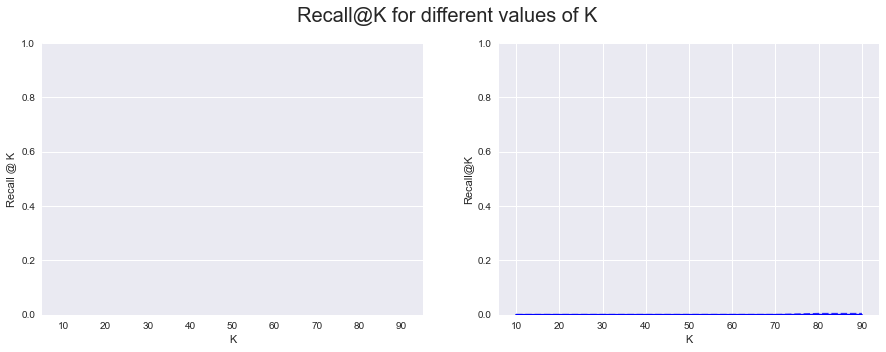

In [52]:
results = RatK(model, test_loader, True)
print(results)

In [57]:
GLOBAL_VALUE_COUNTS = original_csv.PRODUCT_ID.value_counts()
def top_K(K):
    codes = list(GLOBAL_VALUE_COUNTS[:K].reset_index()['index'])
    pred = torch.zeros(num_all_unique_items)
    for code in codes:
        pred[reverse_uid[str(code)]] = 1
    return pred


def hh_top(K, Xbaskets):
    total = torch.zeros(num_all_unique_items)
    for batch in Xbaskets[:-1]:
        total += batch.y.to_dense()
    indices = torch.argsort(total, descending=True)[:K]
    pred = torch.zeros(num_all_unique_items)
    for i in indices:
        pred[i] = 1
    return pred

Calculating baselines: 100%|██████████| 159/159 [00:54<00:00,  2.93it/s]


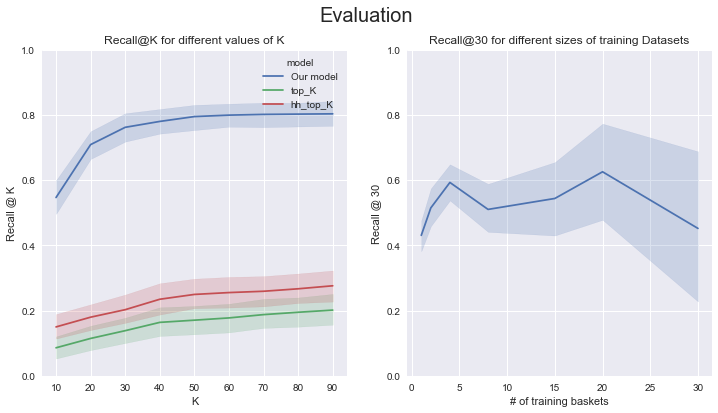

In [67]:
def baselines(model, top_K, hh_top, test_loader, show_plot=True, save_fig=False):
    results2 = {'#baskets' : [], 'R@30' : []}
    for batch in tqdm(test_loader, desc='Calculating effect of X-size'):
        ids = torch.tensor([int(i[0]) for i in list(batch[-1].id.values())])
        model.eval()
        for size in [1,2,4,8,15,20,30]:
            try:
                train_list = batch[:size]
                target = batch[size]
                with torch.no_grad():
                    output = model(train_list, ids)
                results2['#baskets'].append(size)
                results2['R@30'].append(sum(el in torch.argsort(output, descending=True)[:30] for el in  target.y.to_dense().nonzero())/len(target.y.to_dense().nonzero()))
            except IndexError: continue




    results = {'model' : [], 'K' : [], 'R@K' : []}
    for batch in tqdm(test_loader, desc='Calculating baselines'):
        ids = torch.tensor([int(i[0]) for i in list(batch[-1].id.values())])
        train_list = batch[:-1]
        model.eval()
        with torch.no_grad():
            my_outout = model(train_list, ids)
        for K in range(10,100,10):
            results['model'].append('Our model')
            results['K'].append(K)
            results['R@K'].append(sum(el in torch.argsort(my_outout, descending=True)[:K] for el in batch[-1].y.to_dense().nonzero())/len(batch[-1].y.to_dense().nonzero()))

            pred_topK = top_K(K)
            results['model'].append('top_K')
            results['K'].append(K)
            results['R@K'].append(sum(el in torch.argsort(pred_topK, descending=True)[:K] for el in batch[-1].y.to_dense().nonzero())/len(batch[-1].y.to_dense().nonzero()))

            results['model'].append('hh_top_K')
            results['K'].append(K)
            pred_hh_top = hh_top(K, train_list)
            results['R@K'].append(sum(el in torch.argsort(pred_hh_top, descending=True)[:K] for el in batch[-1].y.to_dense().nonzero())/len(batch[-1].y.to_dense().nonzero()))



    df = pd.DataFrame(results)
    df2 = pd.DataFrame(results2)
    plt.style.use('seaborn')
    size = (12, 6)
    fig, ax = plt.subplots(1,2, figsize=size)
    sns.lineplot(data=df, x='K', y='R@K', hue='model', ax=ax[0])
    sns.lineplot(data=df2, x='#baskets', y='R@30', ax=ax[1])
    ax[0].set_xlabel('K')
    ax[0].set_ylabel('Recall @ K')
    ax[0].set_ylim(0,1)
    ax[0].set_title('Recall@K for different values of K')
    ax[1].set_title('Recall@30 for different sizes of training Datasets')
    ax[1].set_xlabel('# of training baskets')
    ax[1].set_ylabel('Recall @ 30')
    ax[1].set_ylim(0,1)
    plt.suptitle('Evaluation', fontsize=20)


    return {'df' : df, 'fig' : fig, 'df2' : df2}
results = baselines(model, top_K, hh_top, test_loader, True)